In [1]:
!pwd

/dli/task/ast


In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [3]:
#!wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_1.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_2.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_3.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_4.zip?download=1

In [4]:
# !unzip /content/humbugdb_neurips_2021_1.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_2.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_3.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_4.zip?download=1 -d '/content/HumBugDB/data/audio'

In [5]:
!pip install torch_audiomentations
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 47 kB 5.7 MB/s eta 0:00:011
     |████████████████████████████████| 59 kB 23.5 MB/s eta 0:00:01
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21895 sha256=3b33033da597495e57a10299bc71be735cf8ca00be43bc072d36fcd081150595
  Stored in directory: /tmp/pip-ephem-wheel-cache-3g3buyox/wheels/85/89/4f/88596b58a42ee452100fe1cd6ac31265bb192e597cf85908da
Successfully built julius
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 285 kB 6.8 MB/s eta 0:00:01


In [6]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [7]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [8]:
# other dependencies
#!pip install timm ipywidgets

In [9]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [10]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [11]:
!pwd

/dli/task/ast


In [12]:
# humbug main imports

import os
import pandas as pd
import sys
#sys.path.insert(0, os.path.abspath('../src'))
import config 
#from evaluate import get_results
import numpy as np
import wget
# Troubleshooting and visualisation
import IPython.display as ipd


In [13]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [14]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
#from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from timm.models.layers import to_2tuple,trunc_normal_
#from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [15]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [16]:
#torch.autograd.set_detect_anomaly(True)

In [17]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers=8
pin_memory=True
#train_size = 100
batch_size = 64
test_batch_size = 64
config.lr = 0.0015
config.max_overrun = 100
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 200

In [18]:
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [19]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]


### Read CSV and get train/test groups

In [20]:
# if DEBUG:
#     df = pd.read_csv(config.data_df_msc_test)
# else:
df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [21]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [22]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
# other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
# df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [23]:
df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
#other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
#df.loc[other_df_ind,'specie_ind']= other_ind        

At this stage we have all extracted the data with specie information and have encoded the specie encoding in a col = 'specie_ind'

In [24]:
#extracting the TZ and Cup data- this is as per the humbug paper

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [25]:
df_all.reset_index(inplace=True)

In [26]:
df_all

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
2,1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
4,1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,4546,222615,30.72,IFA_86_39_3439.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2284,4547,222585,25.60,IFA_86_40_3440.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2285,4548,222586,40.90,IFA_87_10_3450.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2286,4549,222596,40.90,IFA_87_11_3451.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


### Train-Test split( avoiding sklearn )

In [27]:
np.random.seed(42)
msk_test = np.random.rand(len(df_all)) < 0.2
df_test = df_all[msk_test]
df_train_temp  = df_all[~msk_test]


In [28]:
np.random.seed(42)
msk_train = np.random.rand(len(df_train_temp)) < 0.2
df_val = df_train_temp[msk_train]
df_train  = df_train_temp[~msk_train]

## Let's verify for data leakage by performing an inner-join on id

In [29]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [30]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [31]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


We've confirmed that there is no recording that is common in Train,Test,val

### Next, we perform "offsets", spliting each(long) recording into multiple 1.92 secs chunk. 

In [32]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [33]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 69061
length of test offset = 21731
length of val offset = 18652


In [34]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



### Let's check for data leakage in offsets

In [35]:
pd.merge(df_train_offset , df_test_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [36]:
pd.merge(df_train_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [37]:
pd.merge(df_test_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


### At this stage we've a dataframe of recordin ids and each row corresponds to a 1.92 secs recording or shorter


In [38]:
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [39]:
#Class imbalance 
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.32475453 0.56286269 3.61651655 0.62392491 1.97905204 4.1483061
 3.02156983 5.33207227]


Let us now get the class distribution for each of the dataframes- train,test and val

In [40]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
26582
DF type = train
i = 1
15337
DF type = train
i = 2
2387
DF type = train
i = 3
13836
DF type = train
i = 4
4362
DF type = train
i = 5
2081
DF type = train
i = 6
2857
DF type = train
i = 7
1619


In [41]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
7710
DF type = Val
i = 1
4285
DF type = Val
i = 2
514
DF type = Val
i = 3
3923
DF type = Val
i = 4
620
DF type = Val
i = 5
508
DF type = Val
i = 6
934
DF type = Val
i = 7
158


In [42]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
9311
DF type = test
i = 1
4119
DF type = test
i = 2
950
DF type = test
i = 3
4170
DF type = test
i = 4
1101
DF type = test
i = 5
684
DF type = test
i = 6
963
DF type = test
i = 7
433


In [43]:
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [44]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [45]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

0.96

### Class Defintions

In [46]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=8, fstride=10, tstride=10, input_fdim=1025, input_tdim=31, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
                audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
                wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            sd = torch.load('../../pretrained_models/audioset_10_10_0.4593.pth', map_location=device)
            audio_model = ASTModel(label_dim=8, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            if f_dim < 12:
                new_pos_embed = new_pos_embed[:, :, 6 - int(f_dim/2): 6 - int(f_dim/2) + f_dim, :]
            # otherwise interpolate
            elif f_dim > 12:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

In [47]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [48]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [49]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,221103,0,2.56,7
1,1,221103,5120,2.56,7
2,2,221103,10240,2.56,7
3,3,221103,15360,2.56,7
4,4,221103,20480,2.56,7


In [50]:
def get_error_df(loader , trained_model, DEBUG = False):
    err_dict = {'id': None,
               'label': None,
               'offset':None,
               'y_hat':None}
    model = trained_model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        all_wav_id = []
        all_offset = []
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y,offset,wav_id) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                print("y = " + str(y))
                print("offset = " + str(offset))
                print("wav_id = " + str(wav_id))
                
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
            all_y.append(y.cpu().detach())
            all_wav_id.append(wav_id.cpu().detach())
            all_offset.append(offset.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y).numpy()
        all_y_pred = torch.cat(all_y_pred)
        all_wav_id = torch.cat(all_wav_id)
        all_offset = torch.cat(all_offset)
        
        err_dict['id'] = all_wav_id
        err_dict['label'] = all_y
        err_dict['offset'] = all_offset
        err_dict['y_hat'] = all_y_pred
        df_err = pd.DataFrame.from_dict(err_dict)
        df_err_uniq = df_err[df_err['label']!= df_err['y_hat']]
        df_err_uniq.sort_values(by=['id','offset'])

        
        
        
        if DEBUG:
            print("inside error ....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        #test_loss = test_loss/len(test_loader)
        #test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return df_err_uniq

In [51]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            y_pred_smax = softmax(y_pred)
            preds = torch.argmax(y_pred_smax, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [52]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    #optimiser = timm.optim.create_optimizer_v2(model.parameters(), lr=config_pytorch.lr/100,opt = 'lookahead_adam')
    #Network().parameters(), lr=0.001, momentum=0.9
    optimiser = torch.optim.Adam(model.parameters(),lr=config.lr/100)
    #optimiser = timm.optim.AdamW(model.parameters(), lr=config_pytorch.lr)
    timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    
    #optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    all_train_f1 = []
    all_val_f1 = []
    
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        #tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            #global_step += 1
            # AMP
            x_sum = torch.sum(x,axis = 1)
            x_sum.unsqueeze(dim = 1)
            zero_chk = torch.where((x_sum == 0))[0]
            if len(zero_chk) > 0:
                print("ZERO ENCOUNTER")
                print("x = " +str(x))
                break
                       
            with autocast():
                y_pred = model(x)['prediction']
                y_pred_smax = softmax(y_pred)
                preds = torch.argmax(y_pred_smax, axis = 1)
                loss = criterion(y_pred, y)
            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                
                
            #loss_scaler(loss, optimiser,parameters=model_parameters(model))
            if loss.item() > 10000:
                print("^^^^^^^^^^^^^^^^^ EXPLOSION^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                print("x sum = " + str(torch.sum(x)))
                print("current loss = " + str(loss.item()))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            optimiser.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 5.0 )
            optimiser.step()
            del x
            del y
            del y_pred,preds
        
        #lr_log.append(lr)
        #optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        #all_val_loss.append(val_loss)
        #all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config.max_overrun:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1

In [53]:
# from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


# apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [54]:
class MozTrainDataset_mean_calc(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
                   
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
       # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("offset = " + str(offset))
            print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        x_val = x[:,offset:int(offset+config.rate*self.min_length)]
        
        
        if torch.sum(x_val) == 0:
            print("ZERO TENSOR IN DATASET")
            x_val = x_val + torch.tensor(1e-6)
            
        return (x_val,self.audio_df.loc[idx]['specie_ind'] )


In [55]:
mean = np.array(2.7360104e-05)
type(mean)
std = np.array(0.0061507192)

In [56]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None, mean = np.array(2.7360104e-05), std = np.array(0.0061507192)):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
                   
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
       # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("offset = " + str(offset))
            print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        x_val = x[:,offset:int(offset+config.rate*self.min_length)]
        if mean is None:
            x_val = x_val
        x_val = (x_val - torch.from_numpy(mean))/torch.from_numpy(std)
        
        if torch.sum(x_val) == 0:
            print("ZERO TENSOR IN DATASET")
            x_val = x_val + torch.tensor(1e-6)
            
        return (x_val,self.audio_df.loc[idx]['specie_ind'] )


In [57]:
class MozErrAnalysisDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None,mean = np.array(2.7360104e-05), std = np.array(0.0061507192)):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'],offset, self.audio_df.loc[idx]['id'])


In [58]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None,mean = np.array(2.7360104e-05), std = np.array(0.0061507192)):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("shape of x post augmentation = " + str(x.shape))
            print("offset = " + str(offset))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
            
        x_val = x[:,offset:int(offset+config.rate*self.min_length)]
        if mean is None:
            x_val = x_val
        x_val = (x_val - torch.from_numpy(mean))/torch.from_numpy(std)
          
        if torch.sum(x_val) == 0:
            print("ZERO TENSOR IN DATASET")
            x_val = x_val + torch.tensor(1e-6)
        
        return (x_val,self.audio_df.loc[idx]['specie_ind'] )


In [59]:
def apply_aug(x,rate):
        apply_augmentation = Compose(transforms=[AddColoredNoise(p = .85) ,TimeInversion( p = .75) ,PolarityInversion(p = .25)])
        aug_audio = apply_augmentation(x,sample_rate = rate)
        return(aug_audio)
    

class augment_audio(nn.Module):
    """This is a class to introduce randomness in the data.
    We implement it as a layer in the NN to ensure that it learns from the propertis of the data"""
    def __init__(self , trainable = True, sample_rate = config.rate):
        super().__init__()
        self.trainable = trainable
        self.rate = sample_rate
            
    def forward(self, x):
        x = x.unsqueeze(dim = 1)
           
        if self.trainable:
            x = apply_aug(x , self.rate)
        else:
            x = x
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x.squeeze(dim = 1)

In [60]:
len(df_train_offset)
#df_train_offset.iloc[69061]

69061

In [61]:
df_train_offset.iloc[0]

index              0.00
id            221103.00
offset             0.00
length             2.56
specie_ind         7.00
Name: 0, dtype: float64

In [62]:
def get_mean(loader , call = "train" ):
    mean=[]
    std=[]
    st_time = time.time()
    for i in range(len(loader)):
        audio_input, labels = mean_loader[i]
        cur_mean = torch.mean(audio_input)
        cur_std = torch.std(audio_input)
        if i%5000 == 0:
            print("i = " +str(i))
            curr_time = time.time()
            elap_time = curr_time - st_time
            print("elap_time = " + str(elap_time/60))
        mean.append(cur_mean)
        std.append(cur_std)
        #print(cur_mean, cur_std)
    return np.mean(mean), np.mean(std)


    

In [63]:
# mean_loader = MozTrainDataset_mean_calc(df_train_offset,  config.data_dir, config.min_duration , transform = None )
# print("len of loader = " + str(len(mean_loader)))
# mean=[]
# std=[]
# st_time = time.time()
# for i in range(len(mean_loader)):
#     audio_input, labels = mean_loader[i]
#     cur_mean = torch.mean(audio_input)
#     cur_std = torch.std(audio_input)
#     if i%5000 == 0:
#         print("i = " +str(i))
#         curr_time = time.time()
#         elap_time = curr_time - st_time
#         print("elap_time = " + str(elap_time/60))
        
#     mean.append(cur_mean)
#     std.append(cur_std)
#     #print(cur_mean, cur_std)
# print(np.mean(mean), np.mean(std))


In [64]:
# mean=np.array(np.mean(mean))
# std=np.array(np.mean(std))

In [65]:
# mean1 = np.array(mean)
# std1 = np.array(std)
# print(type(mean))
# print(type(std))


In [66]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, ast_mdl):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = ast_mdl
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        #self.out = nn.Linear(self.backbone.num_features, 1)
        #self.sizer = VT.Resize((image_size,image_size))
        #self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        #self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        #self.norm_layer = Normalization(mode='framewise')
        #self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        #self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x):
        # first compute spectrogram
        if DEBUG:
            print("input shape that goes for augmentation = " + str(x.squeeze().shape))
        #spec = self.augment_layer(x.squeeze())
        if DEBUG:
            print("Out put of augment and input shape that goes for STFT = " + str(x.shape))
        spec = self.spec_layer(x)  # (B, F, T)
        spec = torch.transpose(spec,dim0 = 2, dim1 = 1)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        if DEBUG:
            print("Out put of STFT and input shape that goes for PCEN = " + str(spec.shape))
        #spec = self.pcen_layer(spec)
        if DEBUG:
            print("Out put of PCEN and input shape that goes for NORM = " + str(spec.shape))
        #spec = self.norm_layer(spec)
        
        if DEBUG:
            print("Out put of NORM and input shape that goes for time mask = " + str(spec.shape))
        #spec = self.timeMasking(spec)
        if DEBUG:
            print("Out put of timemask and input shape that goes for freq mask = " + str(spec.shape))
        #spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        #spec = self.sizer(spec)
        #x = spec.unsqueeze(1)
        # then repeat channels
        if DEBUG:
            print("Final shape that goes to backbone = " + str(x.shape))
        if torch.sum(x) == 0:
            print("ZERO INPUT in forward")
            x  = x+torch.tensor(1e-6)
            
            
        x = self.backbone(spec)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [67]:
print(config.data_dir)
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = None , mean = np.array(2.7360104e-05), std = np.array(0.0061507192))
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)
error_dataset = MozErrAnalysisDataset(df_val_offset,  config.data_dir, min_length = config.min_duration)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )

error_loader = torch.utils.data.DataLoader(
        error_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


data/audio


In [68]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 69061
Length of train loader = 1080


In [69]:
# train_itr = iter(train_loader)
# a,b = train_itr.next()
# print(a.shape)
# print(b)

In [70]:
# spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
#                               window='hann', freq_scale='linear', center=True, pad_mode='reflect',
#                            sr=config.rate, output_format="Magnitude", trainable=True,)
# x = spec_layer(a)

In [71]:
#test_mod = Model('convnext_small',224)



In [72]:
# test_mod(a)


## Training

In [73]:
ast_mdl = ASTModel(input_fdim=1025, input_tdim=31)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False


Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_384-d0272ac0.pth" to /root/.cache/torch/hub/checkpoints/deit_base_distilled_patch16_384-d0272ac0.pth


frequncey stride=10, time stride=10
number of patches=202


In [74]:
def load_model(filepath, model=Model(ast_mdl)):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

sampling rate = 16000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0876 seconds


In [75]:
#timm.list_models('conv*', pretrained= True)

In [76]:
# ast_mdl = ASTModel(input_fdim=1025, input_tdim=31)
# x_temp = torch.rand([10,31 ,1025])
#x_temp1 = x_temp.transpose(dim0=1,dim1=2)
#x_temp1.shape
#x_temp2 =  


In [77]:
#y_temp = ast_mdl(x_temp)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=202
sampling rate = 16000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0869 seconds
Training on cuda:0
epoch = 0batch = 0 of 1080duraation = 0.15030497709910076
epoch = 0batch = 200 of 1080duraation = 2.4776930689811705
epoch = 0batch = 400 of 1080duraation = 4.845375700791677
epoch = 0batch = 600 of 1080duraation = 7.156233012676239
epoch = 0batch = 800 of 1080duraation = 9.469190128644307
epoch = 0batch = 1000 of 1080duraation = 11.786671888828277
Epoch: 0, Train Loss: 1.62996600, Train f1: 0.31268052, Val Loss: 0.00396853, Val f1: 0.49132241, overrun_counter -1
Saving model to: models/model_e0_2022_10_14_17_40_28.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

       

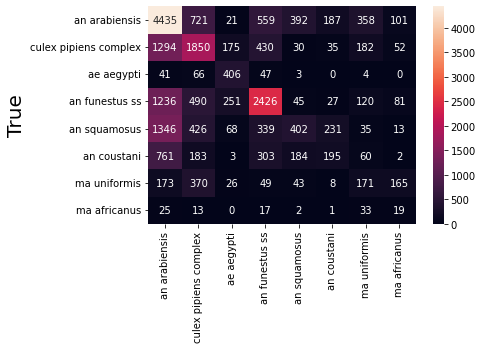

epoch = 1batch = 0 of 1080duraation = 0.08427195151646932
epoch = 1batch = 200 of 1080duraation = 2.4330319205919904
epoch = 1batch = 400 of 1080duraation = 4.730690232912699
epoch = 1batch = 600 of 1080duraation = 7.084681777159373
epoch = 1batch = 800 of 1080duraation = 9.436603951454163
epoch = 1batch = 1000 of 1080duraation = 11.76077393690745
..Overrun....no improvement
Epoch: 1, Train Loss: 1.18735351, Train f1: 0.48102315, Val Loss: 0.00457475, Val f1: 0.45634033, overrun_counter 0
epoch = 2batch = 0 of 1080duraation = 0.08842575152715047
epoch = 2batch = 200 of 1080duraation = 2.4212479750315348
epoch = 2batch = 400 of 1080duraation = 4.722176317373911
epoch = 2batch = 600 of 1080duraation = 7.03812777598699
epoch = 2batch = 800 of 1080duraation = 9.344127968947094
epoch = 2batch = 1000 of 1080duraation = 11.647982354958852
Epoch: 2, Train Loss: 0.85424360, Train f1: 0.59711110, Val Loss: 0.00380161, Val f1: 0.54078145, overrun_counter -1
Saving model to: models/model_e2_2022_1

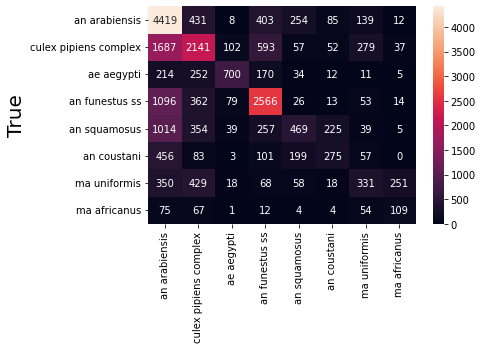

epoch = 3batch = 0 of 1080duraation = 0.09047037363052368
epoch = 3batch = 200 of 1080duraation = 2.483535436789195
epoch = 3batch = 400 of 1080duraation = 4.822064061959584
epoch = 3batch = 600 of 1080duraation = 7.16245874563853
epoch = 3batch = 800 of 1080duraation = 9.470770641167958
epoch = 3batch = 1000 of 1080duraation = 11.797661785284678
..Overrun....no improvement
Epoch: 3, Train Loss: 0.63600401, Train f1: 0.67142054, Val Loss: 0.00393599, Val f1: 0.52709902, overrun_counter 0
epoch = 4batch = 0 of 1080duraation = 0.08355511824289957
epoch = 4batch = 200 of 1080duraation = 2.3711199800173444
epoch = 4batch = 400 of 1080duraation = 4.671264398097992
epoch = 4batch = 600 of 1080duraation = 6.976406121253968
epoch = 4batch = 800 of 1080duraation = 9.294455699125926
epoch = 4batch = 1000 of 1080duraation = 11.587093142668406
Epoch: 4, Train Loss: 0.51827583, Train f1: 0.71670928, Val Loss: 0.00368053, Val f1: 0.57615502, overrun_counter -1
Saving model to: models/model_e4_2022_1

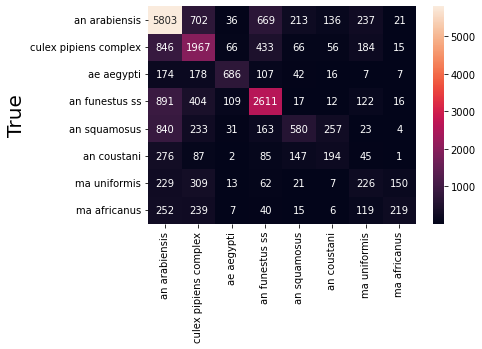

epoch = 5batch = 0 of 1080duraation = 0.09368189573287963
epoch = 5batch = 200 of 1080duraation = 2.421400554974874
epoch = 5batch = 400 of 1080duraation = 4.737494198481242
epoch = 5batch = 600 of 1080duraation = 7.062029985586802
epoch = 5batch = 800 of 1080duraation = 9.37862905661265
epoch = 5batch = 1000 of 1080duraation = 11.73717980782191
..Overrun....no improvement
Epoch: 5, Train Loss: 0.39902903, Train f1: 0.76674928, Val Loss: 0.00389154, Val f1: 0.56624386, overrun_counter 0
epoch = 6batch = 0 of 1080duraation = 0.09235146840413412
epoch = 6batch = 200 of 1080duraation = 2.4251869400342305
epoch = 6batch = 400 of 1080duraation = 4.736047462622325
epoch = 6batch = 600 of 1080duraation = 7.03648300965627
epoch = 6batch = 800 of 1080duraation = 9.337821352481843
epoch = 6batch = 1000 of 1080duraation = 11.62972433567047
..Overrun....no improvement
Epoch: 6, Train Loss: 0.29735298, Train f1: 0.81239131, Val Loss: 0.00430750, Val f1: 0.55136372, overrun_counter 1
epoch = 7batch 

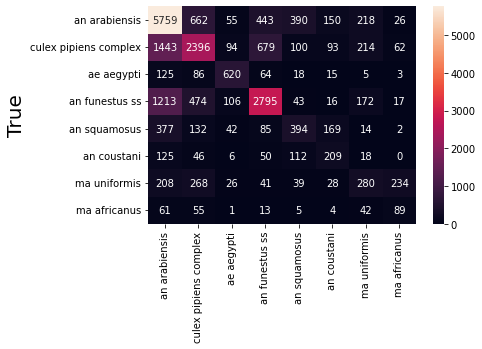

epoch = 8batch = 0 of 1080duraation = 0.08792586723963419
epoch = 8batch = 200 of 1080duraation = 2.4019560257593793
epoch = 8batch = 400 of 1080duraation = 4.752622044086456
epoch = 8batch = 600 of 1080duraation = 7.109378178914388
epoch = 8batch = 800 of 1080duraation = 9.449668713410695
epoch = 8batch = 1000 of 1080duraation = 11.775841939449311
..Overrun....no improvement
Epoch: 8, Train Loss: 0.19012169, Train f1: 0.88010354, Val Loss: 0.00425301, Val f1: 0.59667060, overrun_counter 0
epoch = 9batch = 0 of 1080duraation = 0.10041549603144327
epoch = 9batch = 200 of 1080duraation = 2.374434963862101
epoch = 9batch = 400 of 1080duraation = 4.692397614320119
epoch = 9batch = 600 of 1080duraation = 6.984578140576681
epoch = 9batch = 800 of 1080duraation = 9.292808560530345
epoch = 9batch = 1000 of 1080duraation = 11.589885266621907
..Overrun....no improvement
Epoch: 9, Train Loss: 0.14520981, Train f1: 0.90644844, Val Loss: 0.00485380, Val f1: 0.58657063, overrun_counter 1
epoch = 10b

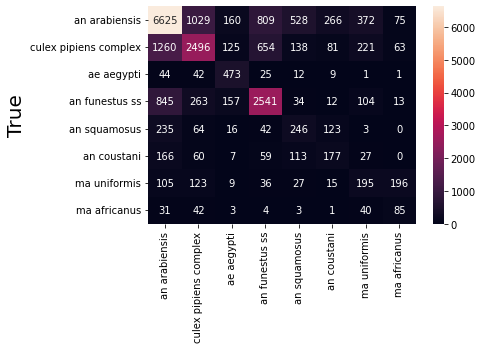

epoch = 13batch = 0 of 1080duraation = 0.09195413986841837
epoch = 13batch = 200 of 1080duraation = 2.413912014166514
epoch = 13batch = 400 of 1080duraation = 4.713014157613118
epoch = 13batch = 600 of 1080duraation = 7.0209383249282835
epoch = 13batch = 800 of 1080duraation = 9.321477631727854
epoch = 13batch = 1000 of 1080duraation = 11.633838979403178
..Overrun....no improvement
Epoch: 13, Train Loss: 0.06343072, Train f1: 0.96167361, Val Loss: 0.00576675, Val f1: 0.60755679, overrun_counter 0
epoch = 14batch = 0 of 1080duraation = 0.09163402716318766
epoch = 14batch = 200 of 1080duraation = 2.4196428338686626
epoch = 14batch = 400 of 1080duraation = 4.701373171806336
epoch = 14batch = 600 of 1080duraation = 7.008986743291219
epoch = 14batch = 800 of 1080duraation = 9.339345387617747
epoch = 14batch = 1000 of 1080duraation = 11.638819682598115
..Overrun....no improvement
Epoch: 14, Train Loss: 0.05199193, Train f1: 0.97044091, Val Loss: 0.00649370, Val f1: 0.59566788, overrun_counte

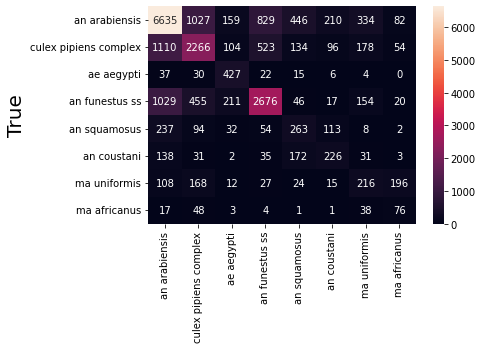

epoch = 21batch = 0 of 1080duraation = 0.08989543120066325
epoch = 21batch = 200 of 1080duraation = 2.440712014834086
epoch = 21batch = 400 of 1080duraation = 4.7959085464477536
epoch = 21batch = 600 of 1080duraation = 7.112842158476512
epoch = 21batch = 800 of 1080duraation = 9.440802991390228
epoch = 21batch = 1000 of 1080duraation = 11.764433558781942
..Overrun....no improvement
Epoch: 21, Train Loss: 0.02596976, Train f1: 0.98731573, Val Loss: 0.00792356, Val f1: 0.60736274, overrun_counter 0
epoch = 22batch = 0 of 1080duraation = 0.09137488603591919
epoch = 22batch = 200 of 1080duraation = 2.38843590815862
epoch = 22batch = 400 of 1080duraation = 4.6811857461929325
epoch = 22batch = 600 of 1080duraation = 6.971460914611816
epoch = 22batch = 800 of 1080duraation = 9.246644632021587
epoch = 22batch = 1000 of 1080duraation = 11.567385788758596
..Overrun....no improvement
Epoch: 22, Train Loss: 0.02317810, Train f1: 0.98954444, Val Loss: 0.00788643, Val f1: 0.60490228, overrun_counter

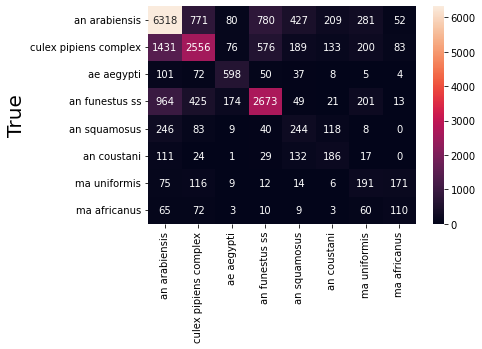

epoch = 25batch = 0 of 1080duraation = 0.10325555006663005
epoch = 25batch = 200 of 1080duraation = 2.475065815448761
epoch = 25batch = 400 of 1080duraation = 4.817484617233276
epoch = 25batch = 600 of 1080duraation = 7.202951737244924
epoch = 25batch = 800 of 1080duraation = 9.59163032770157
epoch = 25batch = 1000 of 1080duraation = 11.97285768588384
..Overrun....no improvement
Epoch: 25, Train Loss: 0.02195898, Train f1: 0.99051617, Val Loss: 0.00814763, Val f1: 0.61202469, overrun_counter 0
epoch = 26batch = 0 of 1080duraation = 0.08597570260365804
epoch = 26batch = 200 of 1080duraation = 2.465588410695394
epoch = 26batch = 400 of 1080duraation = 4.8106374343236284
epoch = 26batch = 600 of 1080duraation = 7.211940630276998
epoch = 26batch = 800 of 1080duraation = 9.540658879280091
epoch = 26batch = 1000 of 1080duraation = 11.914432080586751
..Overrun....no improvement
Epoch: 26, Train Loss: 0.01894444, Train f1: 0.99215215, Val Loss: 0.00801918, Val f1: 0.60656453, overrun_counter 1

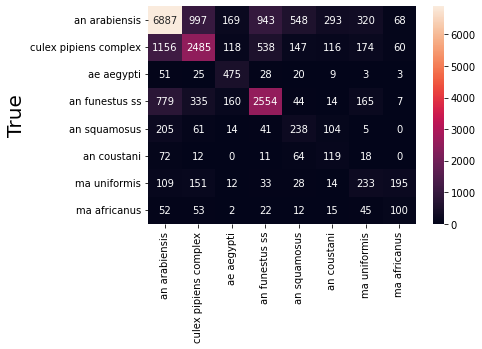

epoch = 30batch = 0 of 1080duraation = 0.09538972775141398
epoch = 30batch = 200 of 1080duraation = 2.460683262348175
epoch = 30batch = 400 of 1080duraation = 4.812778973579407
epoch = 30batch = 600 of 1080duraation = 7.201834825674693
epoch = 30batch = 800 of 1080duraation = 9.582056836287181
epoch = 30batch = 1000 of 1080duraation = 11.935728724797567
..Overrun....no improvement
Epoch: 30, Train Loss: 0.01447686, Train f1: 0.99412187, Val Loss: 0.00867288, Val f1: 0.60977047, overrun_counter 0
epoch = 31batch = 0 of 1080duraation = 0.09566391309102376
epoch = 31batch = 200 of 1080duraation = 2.4279048283894857
epoch = 31batch = 400 of 1080duraation = 4.7609886487325035
epoch = 31batch = 600 of 1080duraation = 7.110113604863485
epoch = 31batch = 800 of 1080duraation = 9.448678565025329
epoch = 31batch = 1000 of 1080duraation = 11.786555242538451
Epoch: 31, Train Loss: 0.01588780, Train f1: 0.99400618, Val Loss: 0.00832509, Val f1: 0.61999986, overrun_counter -1
Saving model to: models

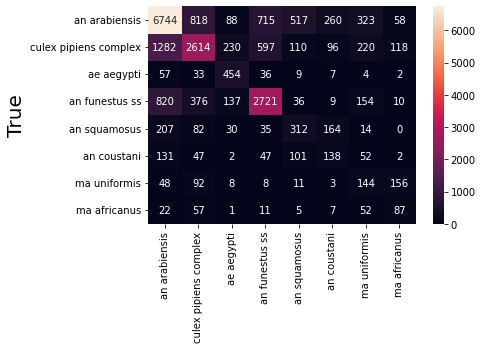

epoch = 32batch = 0 of 1080duraation = 0.0979867696762085
epoch = 32batch = 200 of 1080duraation = 2.500198479493459
epoch = 32batch = 400 of 1080duraation = 4.867514069875082
epoch = 32batch = 600 of 1080duraation = 7.238988343874613
epoch = 32batch = 800 of 1080duraation = 9.61083578268687
epoch = 32batch = 1000 of 1080duraation = 11.979226597150166
..Overrun....no improvement
Epoch: 32, Train Loss: 0.01542831, Train f1: 0.99365797, Val Loss: 0.00862392, Val f1: 0.60819031, overrun_counter 0
epoch = 33batch = 0 of 1080duraation = 0.09613107045491537
epoch = 33batch = 200 of 1080duraation = 2.4401865283648174
epoch = 33batch = 400 of 1080duraation = 4.795411582787832
epoch = 33batch = 600 of 1080duraation = 7.11812975804011
epoch = 33batch = 800 of 1080duraation = 9.444957542419434
epoch = 33batch = 1000 of 1080duraation = 11.805942845344543
..Overrun....no improvement
Epoch: 33, Train Loss: 0.01564310, Train f1: 0.99419394, Val Loss: 0.00883865, Val f1: 0.60068459, overrun_counter 1


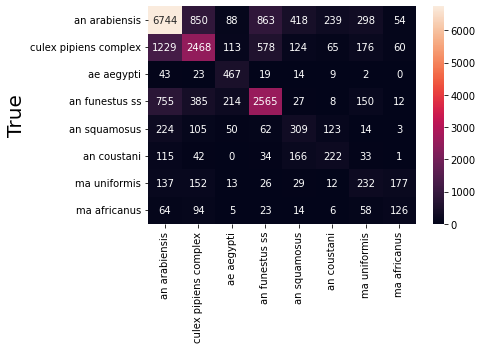

epoch = 41batch = 0 of 1080duraation = 0.10137602885564169
epoch = 41batch = 200 of 1080duraation = 2.4470735152562457
epoch = 41batch = 400 of 1080duraation = 4.853775457541148
epoch = 41batch = 600 of 1080duraation = 7.252697825431824
epoch = 41batch = 800 of 1080duraation = 9.612098077932993
epoch = 41batch = 1000 of 1080duraation = 12.039942467212677
..Overrun....no improvement
Epoch: 41, Train Loss: 0.01279900, Train f1: 0.99536732, Val Loss: 0.00880372, Val f1: 0.61557204, overrun_counter 0
epoch = 42batch = 0 of 1080duraation = 0.09331490198771158
epoch = 42batch = 200 of 1080duraation = 2.4516350666681928
epoch = 42batch = 400 of 1080duraation = 4.752510277430217
epoch = 42batch = 600 of 1080duraation = 7.119204886754354
epoch = 42batch = 800 of 1080duraation = 9.485003089904785
epoch = 42batch = 1000 of 1080duraation = 11.79627982378006
..Overrun....no improvement
Epoch: 42, Train Loss: 0.00965588, Train f1: 0.99594556, Val Loss: 0.00879436, Val f1: 0.62125482, overrun_counter

In [ ]:
ast_mdl = ASTModel(label_dim = 8, input_fdim=1025, input_tdim=31)

model =Model(ast_mdl)
#filepath = "../../models/model_e73_2022_10_08_07_44_27.pth"
#model_epcoh_99 = load_model(filepath,model)
model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
print(len(all_train_f1))
print(len(all_val_f1))
print(len(all_val_loss))
print(len(all_train_loss))


In [ ]:
print("DK")

In [ ]:
all_val_f1_final_XL =  [v for i, v in enumerate(all_val_f1) if i % 2 == 0]

In [ ]:
all_val_loss_final_XL =  [v for i, v in enumerate(all_val_loss) if i % 2 == 0]

In [ ]:
all_train_f1_final_XL =  [v for i, v in enumerate(all_train_f1) if i % 2 == 0]

In [ ]:
plot_df_XL = pd.DataFrame({'train_loss_XL':all_train_loss})

In [ ]:
plot_df_XL['val_f1_XL'] = all_val_f1_final_XL

In [ ]:
plot_df_XL['train_f1_XL'] = all_train_f1_final_XL

In [ ]:
plot_df_XL['val_loss_XL'] = all_val_loss_final_XL

In [ ]:
plot_df_XL

In [ ]:
plot_df_XL.to_csv("plot_df_convNext_XL.csv")

In [ ]:
import torch
x,b = torchaudio.load("../../data/audio/221529.wav")

In [ ]:
val_dataset_new = MozTestDataset(df_val_offset,  config.data_dir, min_length)
val_loader_new = torch.utils.data.DataLoader(
        val_dataset, batch_size=2,
        num_workers=0, pin_memory=pin_memory  )



In [ ]:
val_iter = iter(val_loader_new)
x1,y1 = val_iter.next()
print(x1.shape)
model = model_epcoh_10
model.to('cuda')
x_g = x1.to('cuda')
model(x_g)

In [ ]:
df_error = df_val_offset
model = model_epcoh_10
model.to('cuda')
model.eval()
for idx,(x,y) in enumerate(val_dataset):
    print(idx)
    print(y)
    x = x.to('cuda').float()
    print("x shape = " +str(x.shape))
    #x_new = x.unsqueeze(dim = 1)
    print("x_new shape = " +str(x_new.shape))
    x_new = x.to('cuda')
    y_pred = model(x_new)['prediction']
    y_pred_cpu = y_pred.cpu().detach()
    preds = torch.argmax(y_pred_cpu, axis = 1)
    df_erroriloc[idx]['y_hat'] = preds
    del x_new
    

    

In [ ]:
x = torch.rand(1,15360)
x = x.unsqueeze(dim = 1)

In [ ]:
df_val_offset.head()
path_temp = "../data/audio/"
for i,row in df_val_offset.iterrows():
    print("i = " +str(i))
    print("id = " + str(int(row['id'])))
    file = str(int(row['id']))+".wav"
    print(file)
    path = path_temp + file
    waveform, inp_rate = torchaudio.load(path)
    if inp_rate != config.rate:
        import torchaudio.transforms as T
        resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
        waveform = resampler(waveform)
    if waveform.shape[1] < config.rate*min_length:
        #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
        f_out = pad_mean(waveform)
    else:
        f = waveform[0]
        f_out = f.unsqueeze(0)
    
    
               

In [ ]:
def get_tensor(df):
    
    path_name = "../data/audio/"
    file = df.loc[idx]['id'])}.wav")
    waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("")
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        
        if DEBUG:
            print("shape of x post augmentation = " + str(x.shape))
            
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("returning x of shape ..." + str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [ ]:
#Take the model checkpoint as a parameter as input
# read the val df
#get the tensor rep for the offset.
#pass it to the model get add get the prediction.


In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))